# Graph Neural Network @ ArchDL

In this hands-on we are going to work with Graph Neural Networks.
This kind of neural network allows to deal with complex data structures quite easily.

There are a complete zoo of methods and it will not be possible to cover everything. A good starting point to understand the different model is the article by [Chami and collaborators: Machine learning on graphs: a model and comprehensive taxonomy](https://dl.acm.org/doi/abs/10.5555/3586589.3586678)[1]. 

[1] I. Chami, S. Abu-El-Haija, B. Perozzi, C. Ré, and K. Murphy, “Machine learning on graphs: a model and comprehensive taxonomy,” J. Mach. Learn. Res., vol. 23, no. 1, p. 89:3840-89:3903, Jan. 2022.



## Libraries

In this project we choose the following libraries:
  - [Pytorch](https://pytorch.org/): Math framework
  - [Pytorch Geometric](https://pyg.org/): Graph framework
  - [NetworkX](https://networkx.org/): Tool to manipulate graphs
  - [rdkit](https://www.rdkit.org/): Manipulation of molecules
  
There several other graph frameworks available to deal with GNN:
  - [Jraph (JAX)](https://github.com/google-deepmind/jraph)
  - [DGL (Pytorch, Tensorflow, MXnet)](https://www.dgl.ai/)
  - [Spektral (Tensorflow)](https://graphneural.network/)

In [1]:
# Install dependencies if necessary
#!pip install rdkit networkx ogb torch_geometric

In [2]:
""" Some utilities to display the graphs and molecules """
# RDKit is for molecules manipulation
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolToImage, MolDraw2DCairo

# NetworkX is for graph manipulation 
import networkx as nx
from torch_geometric.utils import to_networkx

# Display pictures
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, imread, axis
import io
from PIL import Image

import numpy as np

def smiles_to_image(smiles):
    """
        Convert a SMILES string to a picture of the molecule
        @param smiles(str): the SMILES descriptor of the molecule
        @return the bytes for the pictures of the molecule given in the SMILES
    """
    return MolToImage(MolFromSmiles(smiles), size=(300,300))

def display_row(pictures, picture_height=5, picture_width=5):
    """ 
        Display the pictures in line
        @param pictures(list(bytes)): a list of bytes pictures
        @param picture_height(float): the height of one picture
        @param picture_width(float): the width of one picture
    """
    num_pic = len(pictures)
    fig = figure(figsize=(num_pic*picture_width, picture_height))
    for i in range(num_pic):
        fig.add_subplot(1, num_pic, i+1)
        imshow(pictures[i])
        axis('off')

def compare_mol_graph(smiles, nx_graph, picture_height=5, picture_width=5):
    """ 
        Put side to side a molecule and the graph
        @param smiles(str): the SMILES descriptor of the molecule
        @param nx_graph(nx.Graph): the graph in networkx format
        @param picture_height(float): the height of one picture
        @param picture_width(float): the width of one picture
    """
    # Get position of the atom in the drawing
    mol = MolFromSmiles(smiles)
    draw = MolDraw2DCairo(300, 300)
    draw.DrawMolecule(mol)
    draw.FinishDrawing()
    coords = [[draw.GetDrawCoords(i).x, draw.GetDrawCoords(i).y] for i in range(mol.GetNumAtoms())] 
    
    # Save the graph to a picture
    fig = figure(figsize=(picture_width, picture_height))
    graph_io = io.BytesIO()
    nx.draw(nx_graph, pos=coords)
    fig.savefig(graph_io, format="png")
    graph_pic = Image.open(graph_io)
    plt.close()
    
    # Then put both images side to side
    fig = figure(figsize=(2*picture_width, picture_height))
    fig.add_subplot(1, 2, 1)
    imshow(graph_pic)
    axis('off')
    fig.add_subplot(1, 2, 2)
    imshow(smiles_to_image(smiles))
    axis('off')
    
def print_graph_adjacency(nx_graph):
    """
        Print side by side the graph and the adjacency matrix
        @param nx_graph(nx.Graph): the graph in networkx format
    """
    num_nodes = nx_graph.number_of_nodes()
    # Avoid node overlapping
    pos = nx.spring_layout(nx_graph, k=0.5, seed=4242424)
    # Get the adjacency matrix in a dense format instead of COO
    adjacency = nx.adjacency_matrix(nx_graph).todense()
    # Plot
    fig, axes = plt.subplots(1, 2)

    ## Plot the graph
    nx.draw(nx_graph, ax=axes[0], pos=pos, with_labels=True)

    ## Plot the adjacency matrix
    axes[1].imshow(adjacency)

    # Gridlines based on minor ticks
    axes[1].set_xticks(np.arange(0.5, num_nodes-0.5, 1), minor=True)
    axes[1].set_yticks(np.arange(0.5, num_nodes-0.5, 1), minor=True)
    axes[1].grid(which='minor', color='w', linestyle='-', linewidth=2)

    # Plot ticks with an interval of 1
    plt.xticks(np.arange(0, num_nodes, 1.0))
    plt.yticks(np.arange(0, num_nodes, 1.0))

    # Display
    plt.show()
    
    
def print_accuracy_curves(learning_curves, train_key="train", validation_key="validation", test_key="test"):
    """
        Print the accuracies for training, validation, test
        @param learning_curves(dict): dictionary hold the accuracy curves
        @param train_key(str): key to get the train curve
        @param validation_key(str): key to get the validation curve
        @param test_key(str): key to get the test curve
    """
    
    train_acc = np.array(learning_curves[train_key])
    validation_acc = np.array(learning_curves[validation_key])
    test_acc = np.array(learning_curves[test_key])

    plt.plot(train_acc, label="Train")
    plt.plot(validation_acc, label="Validation")
    plt.plot(test_acc, label="Test")
    
    plt.legend()
    plt.show()

The Hands-on is divided in two independent parts.

1. In this part we are going to use pytorch-geometric and networkx to build and analyse some graphs
2. This parts shows the implementation of a Message Passing Graph Convolution Network which is applied to a dataset from the OpenGraph Benchmark

# Pytorch Geometric and networkX for building and analizing graph
We will go through some basics of graph manipulation with pytorch geometric and networkx.

First we are going to create a graph by defining:
- the nodes features
- the edges

In [3]:
import torch
import random
from torch_geometric.data import Data
# Number of nodes in the graph
num_nodes = 7 # random
# Minimum number of edges for each node
min_edges = 1
# Maximum number of edges for each node
max_edges = 3
# Define some random node features
feature_size = (num_nodes, random.randint(1,5))
nodes_features = torch.rand(feature_size)

# Random initialization of the edges
edge_index = []
for node in range(num_nodes):
    for edge in range(random.randint(min_edges, max_edges)):
        b_node = random.randint(0,num_nodes-1)   
        
        if [node, b_node] not in edge_index: 
            print(f'+ {node, b_node}')
            edge_index.append([node, b_node])  
            
# torch geometric expects edges to be in the form [[list_origin_nodes], [list_destination_nodes]]
# so we transpose!
edge_index = torch.tensor(edge_index, dtype=torch.int64).T
# Create the graph and check the validity
graph_data = Data(x=nodes_features, edge_index=edge_index)
print(f"Data are valid? {graph_data.validate(raise_on_error=True)}")

+ (0, 0)
+ (1, 1)
+ (2, 1)
+ (3, 4)
+ (4, 2)
+ (4, 4)
+ (5, 2)
+ (5, 1)
+ (5, 6)
+ (6, 6)
Data are valid? True


## Questions

We want you to find some information about the graph defined above (variable `graph_data`). 

1. Use the pytorch geometric API to get:
- the number of nodes and how many features
- the number of edges and how many features
- is the graph directed ?
- the adjacency list

In [4]:
# Insert code here
print(f"Num nodes: {graph_data.num_nodes}; Num features per node: {graph_data.num_node_features}")
print(f"Num edges: {graph_data.num_edges}; Num feature per edge: {graph_data.num_edge_features}")
print(f"The graph is: {'directed' if graph_data.is_directed() else 'undirected'}")
print(f'Adjacency list:\n{graph_data.edge_index.T}')

Num nodes: 7; Num features per node: 3
Num edges: 10; Num feature per edge: 0
The graph is: directed
Adjacency list:
tensor([[0, 0],
        [1, 1],
        [2, 1],
        [3, 4],
        [4, 2],
        [4, 4],
        [5, 2],
        [5, 1],
        [5, 6],
        [6, 6]])


<details>
    <summary>Help</summary>
    <a href="https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html"> https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html</a>
    
</details>

<details>
    <summary>Answer</summary>
<code>
print(f"Num nodes: {graph_data.num_nodes}; Num features per node: {graph_data.num_node_features}")
print(f"Num edges: {graph_data.num_edges}; Num feature per edge: {graph_data.num_edge_features}")
print(f"The graph is: {'directed' if graph_data.is_directed() else 'undirected'}")
print(f'Adjacency list:\n{graph_data.edge_index.T}')
</code>
<details>

2. Undirected Graph 

Because of the way we defined the graph it is likely that you will find that it is directed.
Use torch_geometric to create an undirected graph from this one.
To do so you need to use Data class with a modified edge_index.
Once done answer the same questions.

In [5]:
# Insert code here
from torch_geometric.utils import to_undirected
undirected_graph_data = Data(x=nodes_features, edge_index=to_undirected(edge_index))
print(f"Num nodes: {undirected_graph_data.num_nodes}; Num features per node: {undirected_graph_data.num_node_features}")
print(f"Num edges: {undirected_graph_data.num_edges}; Num feature per edge: {undirected_graph_data.num_edge_features}")
print(f"The graph is: {'directed' if undirected_graph_data.is_directed() else 'undirected'}")
print(f'Adjacency list:\n{undirected_graph_data.edge_index.T}')

Num nodes: 7; Num features per node: 3
Num edges: 16; Num feature per edge: 0
The graph is: undirected
Adjacency list:
tensor([[0, 0],
        [1, 1],
        [1, 2],
        [1, 5],
        [2, 1],
        [2, 4],
        [2, 5],
        [3, 4],
        [4, 2],
        [4, 3],
        [4, 4],
        [5, 1],
        [5, 2],
        [5, 6],
        [6, 5],
        [6, 6]])


<details>
    <summary> Help </summary>
    <a href="https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.to_undirected"> https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.to_undirected</a>
</details>
<details>
    <summary>Answer</summary>
<code>
from torch_geometric.utils import to_undirected
undirected_graph_data = Data(x=nodes_features, edge_index=to_undirected(edge_index))
print(f"Num nodes: {undirected_graph_data.num_nodes}; Num features per node: {undirected_graph_data.num_node_features}")
print(f"Num edges: {undirected_graph_data.num_edges}; Num feature per edge: {undirected_graph_data.num_edge_features}")
print(f"The graph is: {'directed' if undirected_graph_data.is_directed() else 'undirected'}")
print(f'Adjacency list:\n{undirected_graph_data.edge_index.T}')
</code>
</details>

3. Information about nodes

Print the degree matrix of our directed graph (`graph_data`) and tell how many nodes are connected to the first one.

In [6]:
# Insert code here
from torch_geometric.utils import degree
degree = degree(graph_data.edge_index[0], num_nodes)
print(f'Degree matrix: {degree}')
print(f"Number of nodes connected to node 0: {degree[0]}")

Degree matrix: tensor([1., 1., 1., 1., 2., 3., 1.])
Number of nodes connected to node 0: 1.0


<details>
    <summary>Help</summary>
    <a href="https://pytorch-geometric.readthedocs.io/en/2.4.0/_modules/torch_geometric/utils/degree.html"> https://pytorch-geometric.readthedocs.io/en/2.4.0/_modules/torch_geometric/utils/degree.html</a>
</details>
<details>
    <summary>Answer</summary>
<code>
from torch_geometric.utils import degree
degree = degree(graph_data.edge_index[0], num_nodes)
print(f'Degree matrix: {degree}')
print(f"Number of nodes connected to node 0: {degree[0]}")
</code>
</details>

## Enhance the graph

Our graphs does not have any edge attribute (or features) nor data on which to train on (ground-truth labels).
Even though you are free to name those data the way you want it is common to follow those rules to ease the life of the API:
- edge attribute: "edge_attr"
- ground-truth labels: "y"

### Exercise

1. Add edge attributes to the directed graph `graph_data`
   - random torch tensor with a random.randint number of elements for each node
   - type torch.float64
2. Add a ground-truth label
    - random torch scalar (tensor with only one element)
    - type torch.float64
3. Print the shape of the edge attr with pytorch API

In [7]:
# Insert code here
graph_data["edge_attr"] = torch.rand((graph_data.num_edges, random.randint(1, 10)))
graph_data["y"] = torch.rand((1,1), dtype=torch.float64)
print(f'Size of edge.attr: {graph_data.edge_attr.size()}')

Size of edge.attr: torch.Size([10, 2])


<details>
    <summary> Answer </summary>
<code>
graph_data["edge_attr"] = torch.rand((graph_data.num_edges, random.randint(1, 10)))
graph_data["y"] = torch.rand((1,1), dtype=torch.float64)
print(graph_data.edge_attr.size())
</code>
</details>

## Networkx

Networkx is a library providing a lot of cool utilities to analyse graphs. We are going to see a few of them.
The API is a bit simpler to use than the one from Pytorch Geometric to our taste.

Pytorch geometric provides utilities to convert from/to networkx format in `torch_geometric.utils`.

1. Convert `graph_data` to a networkx format `nx_graph`
2. Print the degree matrix and the adjacency matrix

In [8]:
# Insert code here
from torch_geometric.utils import to_networkx
import networkx as nx
nx_graph = to_networkx(graph_data)
print('Degree:    ',nx_graph.degree())
print('Degree out:',nx_graph.out_degree(),'<<<')
print('Degree in: ',nx_graph.in_degree())
print(nx.adjacency_matrix(nx_graph))

Degree:     [(0, 2), (1, 4), (2, 3), (3, 1), (4, 4), (5, 3), (6, 3)]
Degree out: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 3), (6, 1)] <<<
Degree in:  [(0, 1), (1, 3), (2, 2), (3, 0), (4, 2), (5, 0), (6, 2)]
  (0, 0)	1
  (1, 1)	1
  (2, 1)	1
  (3, 4)	1
  (4, 2)	1
  (4, 4)	1
  (5, 1)	1
  (5, 2)	1
  (5, 6)	1
  (6, 6)	1


<details>
    <summary>Help</summary>
    <a href="https://networkx.org/documentation/stable/index.html"> https://networkx.org/documentation/stable/index.html </a>
</details>
<details>
    <summary> Answer </summary>
<code>
from torch_geometric.utils import to_networkx
import networkx as nx
nx_graph = to_networkx(graph_data)
print('Degree:    ',nx_graph.degree())
print('Degree out:',nx_graph.out_degree())
print('Degree in: ',nx_graph.in_degree())
print(nx.adjacency_matrix(nx_graph))
</code>
</details>
    

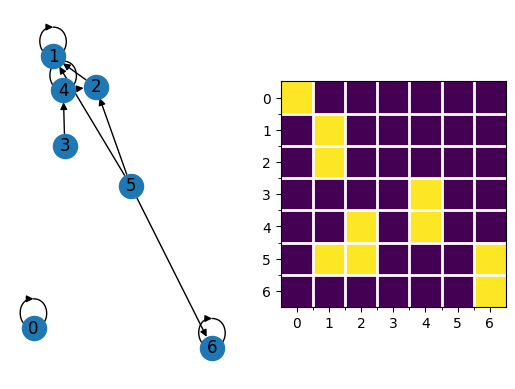

In [9]:
# Print the graph and the adjacency matrix
print_graph_adjacency(nx_graph)

# Let's work with a real dataset

## MolHIV Dataset

We choose a dataset from the [Open Graph Benchmark](https://ogb.stanford.edu/).
This is a repository of dataset where people can submit their performance on several kinds of tasks.

We are going to work with the [MolHIV](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol) whose goal is to predict if a molecule is active as a drug against HIV. This link will be helpful since it gives several hints. You will have to use it!

It contains molecules in the [SMILES](https://fr.wikipedia.org/wiki/Simplified_Molecular_Input_Line_Entry_Specification) format which allows to represent the molecules in a consended way.
For example, caffeine is represented as `CN1C=NC2=C1C(=O)N(C(=O)N2C)C`.

In [10]:
# Download Dataset
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader

dataset_name = "ogbg-molhiv"
dataset_root = "./dataset"
dataset = PygGraphPropPredDataset(name=dataset_name, root=dataset_root)

### Lets see what is inside the dataset

The dataset stored in `dataset` variable is processed and the information is not easy to interpret.
OGB provides the dataset in a raw form and we are going to use it to visualize some of the molecules.

#### Exercise

1. Use a pandas dataframe to load the raw dataset in `dataset/ogbg_molhiv/mapping/mol.csv.gz` in a variable `molecules`.
    - pandas can read csv zipped
2. Print the dataframe and find the name of the column in which the activity is stored
3. Split the dataframe in two parts active_molecules, inactive_molecules using a mask
3. Print the total number of molecules, how many are active and inactive

In [11]:
# Insert code here
import pandas as pd

molecules = pd.read_csv(f"{dataset_root}/ogbg_molhiv/mapping/mol.csv.gz")
print(molecules)

active_molecules = molecules[molecules["HIV_active"] == 1]
inactive_molecules = molecules[molecules["HIV_active"] == 0]

print("Molecules in the dataset")
print(f"  - total: {len(molecules)}")
print(f"  - active: {len(active_molecules)} ({len(active_molecules)/len(molecules)*100:5.1f}%)")
print(f"  - inactive: {len(inactive_molecules)} ({len(inactive_molecules)/len(molecules)*100:5.1f}%)")


       HIV_active                                             smiles  mol_id
0               0  CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...     NaN
1               0  C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...     NaN
2               0                   CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21     NaN
3               0    Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1     NaN
4               0                             O=S(=O)(O)CCS(=O)(=O)O     NaN
...           ...                                                ...     ...
41122           0  CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...     NaN
41123           0  Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...     NaN
41124           0  Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...     NaN
41125           0  Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...     NaN
41126           0  CCCCCC=C(c1cc(Cl)c(OC)c(-c2nc(C)no2)c1)c1cc(Cl...     NaN

[41127 rows x 3 columns]
Molecules in the dataset
  - total: 41127
  - acti

<details><summary>Answer</summary>
<code>

import pandas as pd
 
molecules = pd.read_csv(f"{dataset_root}/ogbg_molhiv/mapping/mol.csv.gz")
print(molecules)

active_molecules = molecules[molecules["HIV_active"] == 1]
inactive_molecules = molecules[molecules["HIV_active"] == 0]

print("Molecules in the dataset")
print(f"  - total: {len(molecules)}")
print(f"  - active: {len(active_molecules)} ({len(active_molecules)/len(molecules)*100:5.1f}%)")
print(f"  - inactive: {len(inactive_molecules)} ({len(inactive_molecules)/len(molecules)*100:5.1f}%)")
</code>
</details>

The dataset contains 3.5% of active molecules. Let see if we can train a Graph Neural Network to find them!

## Descriptors for atoms and bonds

The list of descriptors is provided in the [source code](https://github.com/snap-stanford/ogb/blob/master/ogb/utils/features.py).
We have for atoms (nodes in the graph):
- atomic number
- chirality
- degree
- formal electric charge
- number of hydrogen atoms connected
- number of radical electrons
- hybridization state
- part of ring
- aromaticity

And for bonds (edges in the graph):
- bond multiplicity
- stereoisomery info
- conjugation

## Let's have a look at some molecules !

In [12]:
# Get a random sample of active and inactive molecules to display them
num_samples = 3

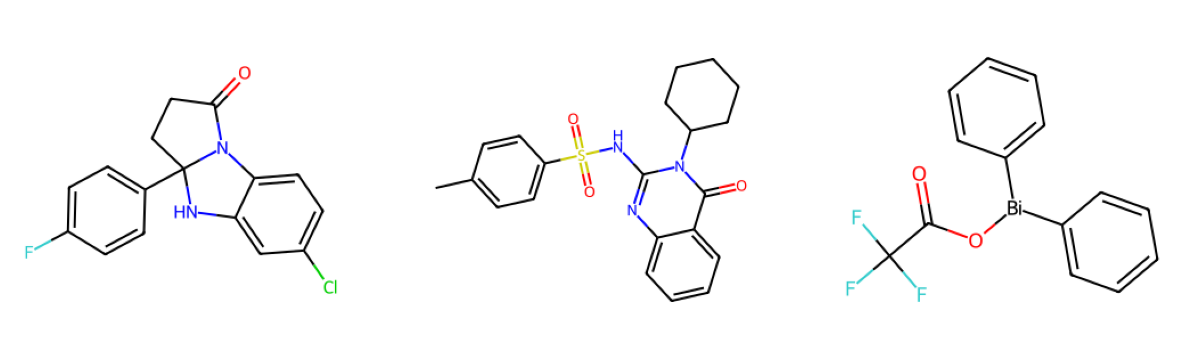

In [13]:
# Inactive molecule
examples_inactive = [smiles_to_image(molecules["smiles"][x]) for x in inactive_molecules.sample(num_samples).index]
display_row(examples_inactive)

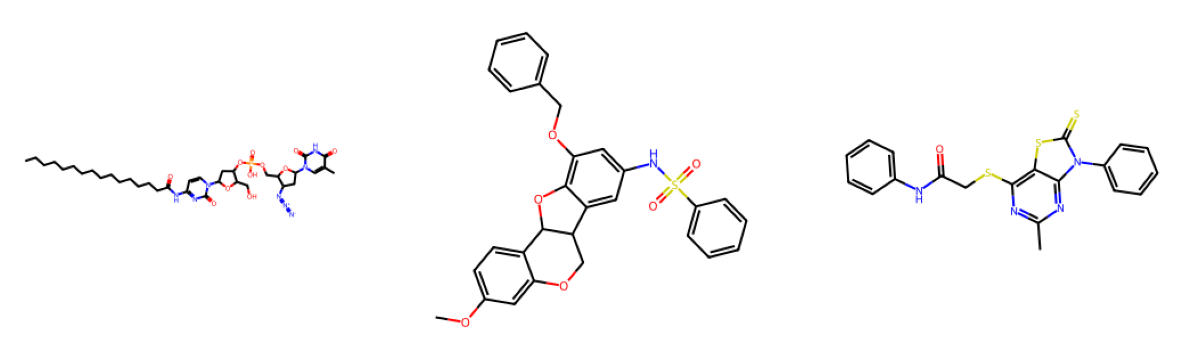

In [14]:
#active molecules
examples_active = [smiles_to_image(molecules["smiles"][x]) for x in active_molecules.sample(num_samples).index]
display_row(examples_active)

## Now let's check the graph structure for one example

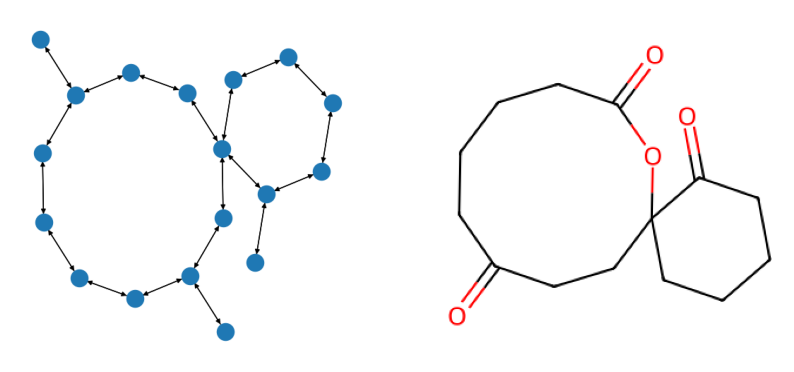

In [15]:
import random
from torch_geometric.utils import to_networkx
sample_num = random.randint(0, len(dataset))
sample_smiles = molecules["smiles"][sample_num]
sample_graph = to_networkx(dataset[sample_num])
compare_mol_graph(sample_smiles, sample_graph)

We see that hydrogen atoms are not included in the graph. That is quite common not to represent them.
However the number of hydrogen atoms connected to one node is included in the node features of the dataset.

## Define the train, validation and test sets

OpenGraph Benchmark defines the train, validation and test datasets so that the competition is fair.

### Exercise

1. Get the index splitter for train, validation and test dataset
2. Define the datasets loaders using the pytorch geometric data loader
   - Give the possibility to change the batch size and the number of workers for the loader
   - Don't forget to shuffle the training set (it is not mandatory for the validation and test sets)
3. Print information about the number of elements and the number of mini-batches in each dataset.
   - Data loaders can be measured with len()

In [16]:
# Insert code here
from torch_geometric.loader import DataLoader

num_workers = 4
# Batch size
batch_size = 128

split_idx = dataset.get_idx_split() 
train_loader = DataLoader(dataset[split_idx["train"]], num_workers=num_workers, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], num_workers=num_workers, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]], num_workers=num_workers, batch_size=batch_size, shuffle=False)
print(f"Dataset size: batch size({batch_size})")
print(f"  - train: {len(split_idx['train'])} (#batches {len(train_loader)})")
print(f"  - validation: {len(split_idx['valid'])} (#batches {len(valid_loader)})")
print(f"  - test: {len(split_idx['test'])} (#batches {len(test_loader)})")

Dataset size: batch size(128)
  - train: 32901 (#batches 258)
  - validation: 4113 (#batches 33)
  - test: 4113 (#batches 33)


<details><summary> Help </summary>
    <a href="https://ogb.stanford.edu/docs/graphprop/">https://ogb.stanford.edu/docs/graphprop/</a>
</details>
<details><summary>Answer</summary>
<pre>
from torch_geometric.loader import DataLoader

num_workers = 4

""" Batch size """
batch_size = 128

split_idx = dataset.get_idx_split() 
train_loader = DataLoader(dataset[split_idx["train"]], num_workers=num_workers, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], num_workers=num_workers, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]], num_workers=num_workers, batch_size=batch_size, shuffle=False)
print(f"Dataset size: batch size({batch_size})")
print(f"  - train: {len(split_idx['train'])} (#batches {len(train_loader)})")
print(f"  - validation: {len(split_idx['valid'])} (#batches {len(valid_loader)})")
print(f"  - test: {len(split_idx['test'])} (#batches {len(test_loader)})")
</pre>
</details>

## How to evaluate the performance of the training

We need a metric to evaluate the accuracy of the model during training.
OGB gives an evaluator class to perform the evaluation.

Depending on the task it will expect different input and output format.

### Exercise
1. Create an evaluator object for the dataset (the `dataset_name` variable holds the name)
2. Print the expected input format and output format
2. Define the acc_crit string which will hold the name of the accuracy method used for the dataset (info in the expected output format)

In [17]:
from ogb.graphproppred import Evaluator
evaluator = Evaluator(name=dataset_name)
print(f"Expected Input Format: {evaluator.expected_input_format}")
print(f"Expected Output Format: {evaluator.expected_output_format}")
acc_crit = "rocauc"

Expected Input Format: ==== Expected input format of Evaluator for ogbg-molhiv
{'y_true': y_true, 'y_pred': y_pred}
- y_true: numpy ndarray or torch tensor of shape (num_graphs, num_tasks)
- y_pred: numpy ndarray or torch tensor of shape (num_graphs, num_tasks)
where y_pred stores score values (for computing AUC score),
num_task is 1, and each row corresponds to one graph.
nan values in y_true are ignored during evaluation.

Expected Output Format: ==== Expected output format of Evaluator for ogbg-molhiv
{'rocauc': rocauc}
- rocauc (float): ROC-AUC score averaged across 1 task(s)



<details><summary>Answer</summary>
<code>
    
from ogb.graphproppred import Evaluator
evaluator = Evaluator(name=dataset_name)
print(evaluator.expected_input_format)
print(evaluator.expected_output_format)
acc_crit = "rocauc"
</code>
</details>

## Define the model 

### Graph Convolution with Message Passing

Our first attempt will be to use a Graph Convolution Network (GCN). This example is a simplification of the example given on [OGB github](https://github.com/snap-stanford/ogb/tree/master/examples/graphproppred/mol) by Weihua Hu – OGB team .

In [18]:
import torch
from torch.nn import BatchNorm1d, ModuleList
import torch.nn.functional as F
# define the pooling method
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

from ogb.graphproppred.mol_encoder import AtomEncoder,BondEncoder

class GCNConv(MessagePassing):
    """
        MessagePassing doc: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html
    """
    def __init__(self, emb_dim, aggr="add"):
        """ 
            Initialize the convolutional layer
            @param emb_dim: dimension of the latent space
            @param aggr: aggregation strategy (default: add)
        """
        super(GCNConv,self).__init__(aggr=aggr)
        self.aggr = aggr
        self.emb_dim = emb_dim
        # Output fully connected layer https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.linear = torch.nn.Linear(emb_dim, emb_dim)
        # Embedding layer https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        self.root_emb = torch.nn.Embedding(1, emb_dim)
        # Encoder for edges (in our case bonds) https://github.com/snap-stanford/ogb/blob/master/ogb/graphproppred/mol_encoder.py
        self.bond_encoder = BondEncoder(emb_dim = emb_dim)
    
    def forward(self, x, edge_index, edge_attr):
        x = self.linear(x)
        edge_embedding = self.bond_encoder(edge_attr)
        
        row, col = edge_index
        
        deg = degree(row, x.size(0), dtype=x.dtype) + 1
        deg_inv_sqrt = deg.pow(0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, edge_attr=edge_embedding, norm=norm) + F.relu(x + self.root_emb.weight)*1.0/deg.view(-1,1)
    
    def message(self, x_j, edge_attr, norm):
        # Flatten the norm tensor
        return norm.view(-1, 1) * F.relu(x_j + edge_attr)
    
    def update(self, aggr_out):
        return aggr_out
                              
class GNN(torch.nn.Module):
    """ Define the GNN """
    def __init__(self, num_tasks:int=1, 
                 num_layers:int=4, 
                 emb_dim:int=100, 
                 drop_ratio:float=0.1):
        """
            Initialize GNN
            @param num_tasks: number of tasks fort the classification
            @param num_layers: number of GNN convolution layers
            @param emb_dim: dimension of the latent space
            @param drop_ratio: dropout ratio
        """
        super(GNN,self).__init__()
        self.num_tasks = num_tasks
        self.num_layers = num_layers
        self.emb_dim = emb_dim
        self.drop_ratio = drop_ratio
        
        self.convs = ModuleList()
        self.batch_norms = ModuleList()
        self.atom_encoder = AtomEncoder(emb_dim)
        
        for _ in range(self.num_layers):
            self.convs.append(GCNConv(self.emb_dim))
            self.batch_norms.append(BatchNorm1d(self.emb_dim))
        
        # Define pooling
        self.pool = global_max_pool
        
        # Define the linear layer
        self.prediction_linear_layer = torch.nn.Linear(emb_dim, num_tasks)
    
    def forward(self, batch_data):
        """ Forward pass """
        x = batch_data.x
        edge_index = batch_data.edge_index
        edge_attr = batch_data.edge_attr
        batch = batch_data.batch
        h = self.atom_encoder(x)
        for layer in range(self.num_layers-1):
            h = self.convs[layer](h, edge_index, edge_attr)
            h = self.batch_norms[layer](h)
            h = F.relu(h)
            h = F.dropout(h, self.drop_ratio, training = self.training)
        # Do not apply ReLU on last layer
        h = self.convs[-1](h, edge_index, edge_attr)
        h = self.batch_norms[-1](h)
        h = F.dropout(h, self.drop_ratio, training=self.training)
        # We use Jk-concat (Jumping knowledge) "last" strategy so we keep only the last node representation
        #    We could have used a list of the representations and summed them up
        # We also choose not to used residual connections h[i] += h[i-1] 
        
        h_graph = self.pool(h, batch_data.batch)
        return self.prediction_linear_layer(h_graph)

In [19]:
from ogb.graphproppred.mol_encoder import AtomEncoder
from tqdm.notebook import tqdm_notebook as tqdm_nb

@torch.no_grad()
def evaluate(dataloader, device, atom_embedding_dim=100, bond_embedding_dim=100, criterion=torch.nn.BCEWithLogitsLoss(), evaluator=None):
    """ Evaluate the model for validation and test. No gradient computation required"""
    #atom_encoder = AtomEncoder(emb_dim=atom_embedding_dim).to(device)
    model.eval()
    y = []
    y_hat = []
    # Iterate the dataloader
    for data in tqdm_nb(dataloader, position=0, leave=True):
        # Send mini batch to device
        data = data.to(device)
        # Perform the forward pass
        out = model(data)  
        
        # Compute the accuracy
        y.append(data.y.view(out.shape).detach().cpu())
        y_hat.append(out.detach().cpu())
        
    input_dict = {"y_true":torch.cat(y, dim=0).numpy(),
                  "y_pred":torch.cat(y_hat, dim=0).numpy()}
        
    return evaluator.eval(input_dict)

def train(device, atom_embedding_dim=100, bond_embedding_dim=100, criterion=torch.nn.BCEWithLogitsLoss(), evaluator=None):
    """ 
        Train the model 
        @param device: torch device
        @param atom_embedding_dim: dimension of the latent space for atoms
        @param bond_embedding_dim: dimension of the latent space for bonds
        @param criterion: loss function
        @param evaluator: evaluator for the accuracy of the prediction
    """
    # We need to send the encoder to the device
    #atom_encoder = AtomEncoder(emb_dim=atom_embedding_dim).to(device)
    model.train()
    y = []
    y_hat = []
    # Go through the mini-batches
    for data in tqdm_nb(train_loader, position=0, leave=True):
        # Send data to the device
        data = data.to(device)
        # Perform the forward pass
        out = model(data)
        # Compute the accuracy
        y.append(data.y.view(out.shape).detach().cpu())
        y_hat.append(out.detach().cpu())
        # Compute the loss
        loss = criterion(out, data.y.to(torch.float)) # Convert the ground truth to float
        # Perform the backward pass
        loss.backward()
        # Step the optimizer
        optimizer.step()
        # Clear gradients
        optimizer.zero_grad()
    # Compute the accuracy
    y.append(data.y.view(out.shape).detach().cpu())
    y_hat.append(out.detach().cpu())
    input_dict = {"y_true":torch.cat(y, dim=0).numpy(),
                  "y_pred":torch.cat(y_hat, dim=0).numpy()}
    return evaluator.eval(input_dict)

### Build the model and send it to the GPU

In [20]:
# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running on {device}")

# Number of classes
num_classes = len(dataset[0].y)

# Size of the embedding space dimension for atoms
atom_embedding = 50
# We want to save the training curves
learning_curves = {"train":[], "validation": [], "test": []}

model = GNN(num_tasks=num_classes, num_layers=4, emb_dim=atom_embedding).to(device)
print(model)
print(f"Number of trainable parameters (weights): {sum(p.numel() for p in model.parameters())}")

Running on cuda
GNN(
  (convs): ModuleList(
    (0-3): 4 x GCNConv()
  )
  (batch_norms): ModuleList(
    (0-3): 4 x BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (atom_encoder): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 50)
      (1): Embedding(5, 50)
      (2-3): 2 x Embedding(12, 50)
      (4): Embedding(10, 50)
      (5-6): 2 x Embedding(6, 50)
      (7-8): 2 x Embedding(2, 50)
    )
  )
  (prediction_linear_layer): Linear(in_features=50, out_features=1, bias=True)
)
Number of trainable parameters (weights): 22151


### Define the optimizer

In [31]:
# Learning rate of the optimizer
learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Run the training

In [32]:
import sys
import os
from IPython.display import clear_output
from ogb.graphproppred import Evaluator

test_acc = -float('inf') if len(learning_curves["test"]) == 0 else learning_curves["test"][-1]
restart = not len(learning_curves["train"]) == 0
best = "best.pth"

# Set the number of epochs
num_epochs = 50
# Define the loss function
criterion = torch.nn.BCEWithLogitsLoss()

if restart and os.path.isfile(best):
    model.load_state_dict(torch.load(best, weights_only=True))
    print(f"Restart with weights from {best}")
# Iterate over epochs
for epoch in range(1,num_epochs+1):
    
    print(f"Train epoch {epoch:03d}")
    train_acc = train(device, atom_embedding_dim=atom_embedding, criterion=criterion, evaluator=evaluator)[acc_crit]
    learning_curves["train"].append(train_acc)
    
    print(f"Validation epoch{epoch:03d}")
    val_acc = evaluate(valid_loader, device, atom_embedding_dim=atom_embedding, criterion=criterion, evaluator=evaluator)[acc_crit]
    learning_curves["validation"].append(val_acc)
    
    print(f"Test epoch{epoch:03d}")
    current_test_acc = evaluate(test_loader, device, atom_embedding_dim=atom_embedding, criterion=criterion, evaluator=evaluator)[acc_crit]
    learning_curves["test"].append(current_test_acc)
    
    # Print info only if we are getting better
    if current_test_acc > test_acc:
        test_acc = current_test_acc
        current_best = f"Epoch = {epoch:03d}/{num_epochs}, Train Acc = {train_acc:10.4e}, Val Acc = {val_acc:10.4e}, Test Acc = {test_acc:10.4e}"
        torch.save(model.state_dict(), best)
    clear_output()
    print(f"Best: {current_best}")
        

Best: Epoch = 012/50, Train Acc = 8.3105e-01, Val Acc = 7.6412e-01, Test Acc = 7.7023e-01


In [24]:
model


GNN(
  (convs): ModuleList(
    (0-3): 4 x GCNConv()
  )
  (batch_norms): ModuleList(
    (0-3): 4 x BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (atom_encoder): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 50)
      (1): Embedding(5, 50)
      (2-3): 2 x Embedding(12, 50)
      (4): Embedding(10, 50)
      (5-6): 2 x Embedding(6, 50)
      (7-8): 2 x Embedding(2, 50)
    )
  )
  (prediction_linear_layer): Linear(in_features=50, out_features=1, bias=True)
)

# Print the curves

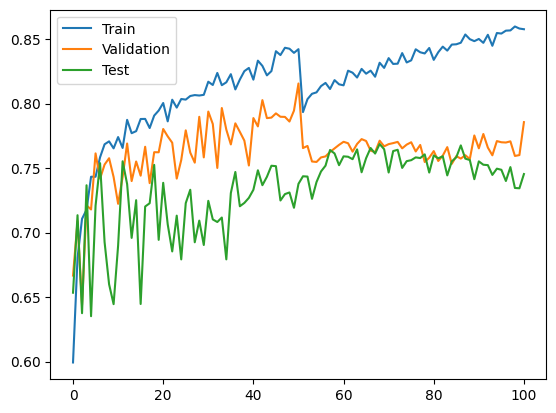

In [30]:
print_accuracy_curves(learning_curves)

### Exercise

1. Go to the leaderboard of the dataset and check the best accuracy scores
2. Play with the hyperparameters to get the best results possible
    - learning rate
    - number of convolutional layer
    - atom embedding dimension

---
<img width="80px" src="./for-notebooks/logo-paysage.svg"></img>